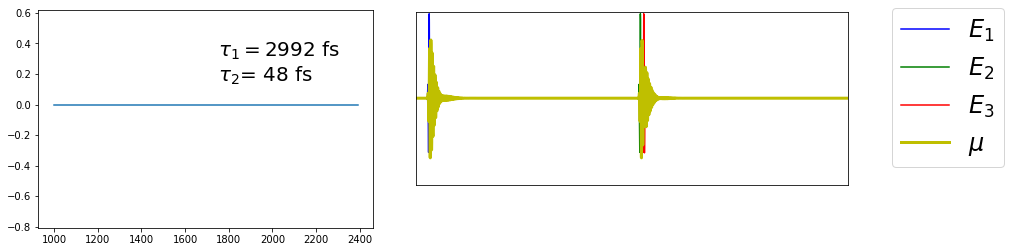

In [1]:
import math
%matplotlib inline
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython import display
import time
import numpy as np

def calc_accel(x,efield):
    aExp = np.exp(-alpha*x)
    ax = - 2.0*Minv*De*alpha*aExp*(1.0 - aExp)
    ax += Qo*efield*Minv #add to it the right side of ax+
    ax[:,0] += -J*x[:,1]*Minv #j is 2x2 matrix currently w 15 at off diagonal matrix
    ax[:,1] += -J*x[:,0]*Minv #make into for loop 
    return ax

def vv_step(x,vx,ax,efield):
    if(Temp==0):
        axrand = 0
    else:
        axrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,1)/M
    xnew = x + B*dt*vx + 0.5*B*dt*dt*(ax + axrand)
    axnew = calc_accel(xnew,efield)
    vxnew = A*vx + 0.5*dt*(A*ax + axnew + 2.0*B*axrand)
    return xnew,vxnew,axnew

def gauss_pulse(t):
    return np.cos(2.0*math.pi*(t-to)*nu)*np.exp(-((t-to)**2)/(2.0*sigma*sigma))

to = 150e-15
sigma = 10e-15
nu = 50e+12

tmax=3000e-15      # Total simulation time in seconds
tau2max = 50e-15 #changed from 50
dt=2e-15     # Time-step in seconds
Nsteps=int((2.0*tmax+tau2max+3.0*sigma*2.355)/dt)
M=12*(1.66054e-24)   # Mass in g
Minv = 1.0/M
Qo = 4.803e-10         # Elementary charge in statCoulombs
taxis = np.arange(0,Nsteps)*dt   # Time axis (array of time steps)

gamma = 500.0e-12  # grams/second
kB = 1.38064852e-16                  # erg/K
Temp = 0.0                           # K
B = 1.0/(1.0 + 0.5*gamma*dt/M)
A = B*(1.0 - 0.5*gamma*dt/M)

wo = 6.28*50e12        # Oscillator (angular) frequency
hbar=1.0546e-27
c = 2.9979e+10

J=(2.0*M*wo*(15)*2.0*math.pi*c)


De = 1e+5*(kB*300.0)

vaxis = np.fft.fftfreq(Nsteps)/(dt*c)

v1 = 1000
v2 = 2400

ndx1 = np.where(np.abs(vaxis-v1)==np.min(np.abs(vaxis-v1)))[0][0]
ndx2 = np.where(np.abs(vaxis-v2)==np.min(np.abs(vaxis-v2)))[0][0]
    
Nmols = 1 #how many random ensembles you have; nproteins+
Nosc = 2 #number of oscillators coupled to each other; would need to change to 8 for sheet; nresidues
W = np.random.normal(wo, 0.1*wo, (Nmols, Nosc))

        
K = M*W**2 #Change to 2d array; make W a 2d matrix
alpha = np.sqrt(K/(2.0*De))
def calc_response(Efield):
    X = np.zeros((Nmols,Nosc))
    VX = np.zeros((Nmols,Nosc))
    AX = calc_accel(X,Efield[0])
    Mu = np.zeros((Nsteps))
    for n in range(0,Nsteps):
        X,VX,AX = vv_step(X,VX,AX,Efield[n])
        Mu[n] = np.mean(X)*Qo #make mean of first column and second correspond to the two oscillators?
    return Mu

tauStep1 = 8*1e-15
tauStep2 = 4*1e-15
Tau1 = np.arange(0.0e-15, tmax, tauStep1)
Tau2 = np.arange(0.0e-15, tau2max, tauStep2)
#pulses after delay of time -> Tau 1&2

Emax = 50e+4
scfac = 8e+26*(Emax/(50e+4))
scfacTime = 4e+18*(Emax/(50e+4)) #look at paper for tmax, scan time; J; difference in frequency of the oscillators 
for n2 in range(0, len(Tau2)):
    tau2 = Tau2[n2]
    for n1 in range(0, len(Tau1)):
        tau1 = Tau1[n1]
        
        E1 = Emax*gauss_pulse(taxis+tau1+tau2-tmax-3.0*sigma*2.355)
        E2 = Emax*gauss_pulse(taxis+tau2-tmax-3.0*sigma*2.355)
        E3 = Emax*gauss_pulse(taxis-tmax-3.0*sigma*2.355)

        Mu123 = calc_response(E1 + E2 + E3)
        Mu12 = calc_response(E1 + E2)
        Mu13 = calc_response(E1 + E3)
        Mu23 = calc_response(E2 + E3)
        Mu1 = calc_response(E1)
        Mu2 = calc_response(E2)
        Mu3 = calc_response(E3)

        Mu2D = Mu123 - Mu12 - Mu23 - Mu13 + Mu1 + Mu2 + Mu3
        fMu2D = np.fft.fft(Mu2D)
        fEprobe = np.fft.fft(E3)

        Sig = -np.imag(fMu2D/fEprobe)

        if (n1==0) and (n2==0):
            SpecMat = np.zeros((len(Tau1),len(Tau2),len(vaxis[ndx1:ndx2])))
            ppPts, = plt.plot(vaxis[ndx1:ndx2], Sig[ndx1:ndx2]*scfac)
            txt = plt.text(1750, 0.15, '$\\tau_1 = $'+str(int(tau1*1e+15))+' fs \n$\\tau_2$= '+str(int(tau2*1e+15))+' fs', fontsize=20)
            display.display(plt.gcf())
            display.clear_output(wait=True)
         
            ax2 = plt.axes([1.0,0.275,1,0.6])
            #fieldPts, = plt.plot(taxis, E1 + E2 + E3, 'k', linewidth=3)
            field1Pts, = plt.plot(taxis, E1/Emax, 'b')
            field2Pts, = plt.plot(taxis, E2/Emax, 'g')
            field3Pts, = plt.plot(taxis, E3/Emax, 'r')
            muPts, = plt.plot(taxis, Mu123, 'y', linewidth=3)
            plt.xticks([])
            plt.yticks([])
            plt.ylim([-1,1])
            plt.xlim([0,dt*Nsteps])
            plt.legend(['$E_1$', '$E_2$', '$E_3$', '$\\mu$'], fontsize=24, loc=(1.1,0.1))
        elif(n1%1==0):
            ppPts.set_ydata(Sig[ndx1:ndx2]*scfac)
            #fieldPts.set_ydata((E1+E2+E3)/(3.0*Emax))
            field1Pts.set_ydata((E1)/(Emax))
            field2Pts.set_ydata((E2)/(Emax))
            field3Pts.set_ydata((E3)/(Emax))
            muPts.set_ydata(Mu123*scfacTime)
            txt.set_text('$\\tau_1 = $'+str(int(tau1*1e+15))+' fs \n$\\tau_2$= '+str(int(tau2*1e+15))+' fs')
            display.display(plt.gcf())
            display.clear_output(wait=True)
        SpecMat[n1,n2,:] = Sig[ndx1:ndx2]


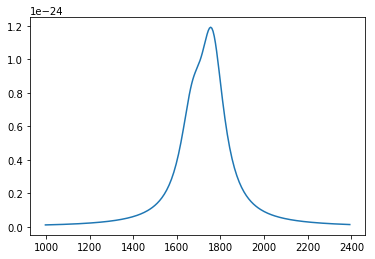

In [8]:
fMu3 = np.fft.fft(Mu3)
signal = -np.imag(fMu3/fEprobe)
signal = signal[ndx1:ndx2]
plt.plot(vaxis[ndx1:ndx2], signal)
#plt.xlim([1550,1750])

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


IndexError: index 2 is out of bounds for size 2

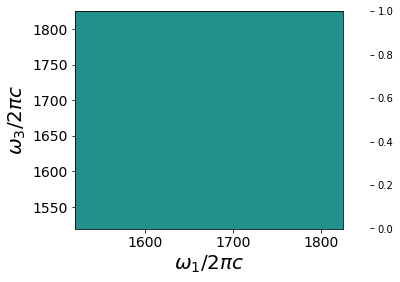

In [11]:
fSpecMat = np.fft.fft(SpecMat, axis=1)
vaxis_tau = np.fft.fftfreq(len(Tau2))/(c*tauStep2)
window = (np.abs(vaxis_tau)<500)
f2DMat = np.zeros(np.shape(fSpecMat))*1j
for n1 in range(0, len(Tau1)):
    for n3 in range(0, len(vaxis[ndx1:ndx2])):
        f2DMat[n1,:,n3] = fSpecMat[n1,:,n3]*window

Mat2D = np.real(np.fft.ifft(f2DMat, axis=1))
Mat2D = np.fft.fft(f2DMat, axis=0)

vaxis1 = np.fft.fftfreq(len(Tau1))/(c*tauStep1)
v1 = 1200
v2 = 2200

a1 = np.where(np.abs(vaxis1-v1)==np.min(np.abs(vaxis1-v1)))[0][0]
a2 = np.where(np.abs(vaxis1-v2)==np.min(np.abs(vaxis1-v2)))[0][0]
vaxis1 = vaxis1[a1:a2]

vaxis3 = vaxis[ndx1:ndx2]

SigMat = Mat2D[a1:a2,0,:]
#SigMat = SigMat/np.max(np.abs(SigMat))
ctrs = np.linspace(-1, 1, 50)
plt.contourf(vaxis1,vaxis3,np.transpose(np.real(SigMat)), ctrs)
ctrs2 = np.linspace(-0.1, 0.1, 10)
plt.contour(vaxis1,vaxis3,np.transpose(np.real(SigMat)), ctrs2)
#plt.contourf(vaxis1,vaxis3,np.tanh(np.tanh(np.transpose(np.real(SigMat)))), ctrs)


plt.set_cmap(plt.cm.get_cmap('brg'))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('$\\omega_3/2\pi c$', fontsize=20)
plt.xlabel('$\\omega_1/2\pi c$', fontsize=20)


plt.xlim([1520,1825])
plt.ylim([1520,1825])
plt.colorbar()
#plt.show(test)
plt.show()

In [9]:
Mu3

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         1.85149776e-33,   9.59658682e-34,   1.70008047e-34])